# Statistical Arbitrage Based on Causal Relationship:
>* How is the causal relationship used here: The Causal Relationship here is used to construct the stationary price series.
>* The workflow: Get the stock data in the financial sector within China's stock market.
>*               Apply the causal analysis among the stocks.
>*               Construct the residual price series using the result from Linear Regression
>*               Test the stationarity of the residual series and whether it is a white noise.
>*               Apply the dynamic ARMA model for prediction of the trend and do the trend following trading.


In [4]:
import pandas as pd
import tushare as ts
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = ts.get_industry_classified()
data.head(5)

ModuleNotFoundError: No module named 'tushare'

In [2]:
data[data['code'] == '601107']['name'] 

44    四川成渝
Name: name, dtype: object

In [3]:
housing_sector = data[data['c_name'] == '房地产']
fin_sector = data[data['c_name'] == '金融行业']
trip_sector = data[data['c_name'] == '酒店旅游']

## Let's find the causal relationships among the financial sector

In [4]:
price_fin_sector = {}
for item in fin_sector['code']:
    price_fin_sector[item] = ts.get_hist_data(item)
    

In [5]:
fin_data = pd.DataFrame({})
for item in price_fin_sector:
    try:
        fin_data[item] = price_fin_sector[item]['close']
    except:
        continue
fin_data = fin_data.dropna(axis = 1)

In [6]:
print("There are {} of financial sector stocks in total".format(len(fin_sector)))
print("We actually get {} of financial sector stocks in total after droping the NA data due to the timeslots".format(fin_data.shape[1]))

There are 51 of financial sector stocks in total
We actually get 14 of financial sector stocks in total after droping the NA data due to the timeslots


In [7]:
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15., 12.]
variable_types = { x: 'c' for x in fin_data.columns}

ic_algorithm = IC(RobustRegressionTest, alpha = 0.1)

graph = ic_algorithm.search(data = fin_data, variable_types = variable_types)


In [8]:
graph.edges(data=True)


[('600000', '600016', {'arrows': ['600000'], 'marked': False}),
 ('600000', '601318', {'arrows': ['600000', '601318'], 'marked': False}),
 ('600015', '600030', {'arrows': ['600015', '600030'], 'marked': False}),
 ('600015',
  '601288',
  {'arrows': ['600015', '601288', '601288'], 'marked': False}),
 ('600015', '601788', {'arrows': ['601788'], 'marked': True}),
 ('600030',
  '601318',
  {'arrows': ['600030', '600030', '601318'], 'marked': False}),
 ('600030', '601688', {'arrows': ['600030', '600030'], 'marked': False}),
 ('600030', '601788', {'arrows': ['600030'], 'marked': False}),
 ('601288', '601328', {'arrows': ['601288'], 'marked': False}),
 ('601288', '601398', {'arrows': ['601288', '601288'], 'marked': True}),
 ('601336', '601601', {'arrows': ['601336', '601601'], 'marked': False}),
 ('601336', '601628', {'arrows': ['601336', '601336'], 'marked': True}),
 ('601398', '601601', {'arrows': ['601398'], 'marked': True}),
 ('601398', '601628', {'arrows': ['601628'], 'marked': True}),
 

In [9]:
from colour import Color

def get_color_range(n, output_type='hex'):
    red = Color('red')
    blue = Color('blue')
    color_range = list(red.range_to(blue, n))
    if output_type == 'hex':
        return [c.get_hex_l() for c in color_range]
    else:
        return [c.get_rgb() for c in color_range]
        
n_nodes = len(graph.nodes())
n_colors = get_color_range(n_nodes)

In [10]:
# Sanitize graph edgges: remove duplicated arrows
sanitized_edges = []
for t in graph.edges(data=True):
    attr = t[2]
    attr['arrows'] = list(set(attr['arrows']))
    sanitized_edges.append((t[0], t[1], attr))

In [11]:
edge_labels = [((u,v,),'CAUSAL') if d['marked'] else ((u,v,),'') for u,v,d in graph.edges(data=True)]
edge_labels = dict(edge_labels)

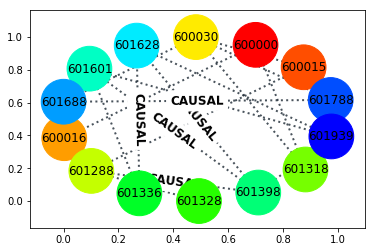

In [12]:
# -*- coding: UTF-8 -*-

pos = nx.spring_layout(graph, k=2000, iterations=1000)

# Add nodes
nx.draw_networkx_nodes(graph, pos, node_color=n_colors, node_size=2000)

# Add labels to nodes
nx.draw_networkx_labels(graph, pos, font_size=12)

# Add edges
nx.draw_networkx_edges(graph, pos, edgelist=sanitized_edges, 
                       arrows=True, 
                       width=2.0,
                       edge_color='#1C2833',
                       style='dotted', 
                       alpha=0.8)

# Add labels to edges
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels,
                             font_size=12,
                             font_weight='bold')

# plt.draw()
plt.show()

In [14]:
causal_graph = {}
for i in range(len(graph)):
    if graph.edges(data=True)[i][2]['marked']:
        if graph.edges(data=True)[i][0] not in causal_graph:
            causal_graph[graph.edges(data=True)[i][0]] = []
        causal_graph[graph.edges(data=True)[i][0]].append(graph.edges(data=True)[i][1])


In [15]:
causal_graph

{'600015': ['601788'],
 '601288': ['601398'],
 '601336': ['601628'],
 '601398': ['601601', '601628']}

In [16]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as adf

def plot_the_residual(target_code, source_code):
    y_1 = price_fin_sector[target_code].sort_index(axis = 0, ascending = True)
    x1_1 = price_fin_sector[source_code[0]].sort_index(axis = 0, ascending = True)
    x2_1 = price_fin_sector[source_code[1]].sort_index(axis = 0, ascending = True)
    y_1_a = np.array(y_1['close'])
    x1_1_a = np.array(x1_1['close'])
    x2_1_a = np.array(x2_1['close'])
    from sklearn.linear_model import LinearRegression as lr
    model = lr()
    model.fit(np.array([x1_1_a,x2_1_a]).T,y_1_a)
    b1, b2 = model.coef_
    short = y_1_a - b1*x1_1_a - b2 * x2_1_a
    print("The single residual's adf test: ", adf(short))
    plt.plot(short)
    plt.title("single residual")
    plt.show()
    return short,b1,b2

The single residual's adf test:  (-2.7537685803963656, 0.06518706177284822, 6, 727, {'1%': -3.439376877165393, '5%': -2.865523768488869, '10%': -2.5688914082860164}, -3125.2787066167703)


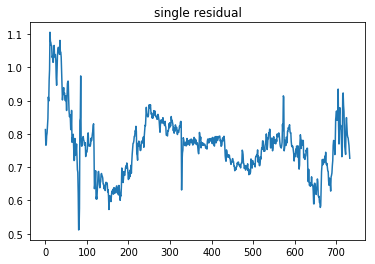

The single residual's adf test:  (-2.88735941243353, 0.046837795297267719, 0, 733, {'1%': -3.439302726125018, '5%': -2.8654910924750547, '10%': -2.5688740002680124}, -1600.8359541426926)


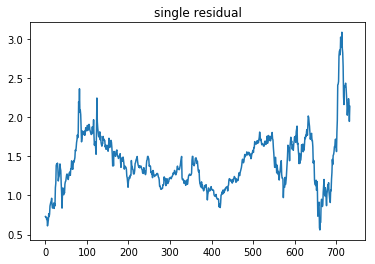

the combined series's adf test:  (-3.3651271628955786, 0.012206709067994169, 2, 731, {'1%': -3.4393273074073045, '5%': -2.8655019247555154, '10%': -2.5688797711097928}, -2638.6214343356469)


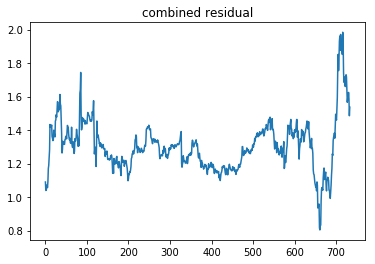

In [17]:
residual1,b1,b2 = plot_the_residual('601288',['601328','601398'])
residual2,b1_,b2_ = plot_the_residual('601398',['601601','601628'])
combined_residual = residual1 + b2*residual2
print("the combined series's adf test: ",adf(combined_residual))
plt.plot(combined_residual)
plt.title("combined residual")
plt.show()

## Apparently the individual price series is unstationary, however the combined series is stationary.

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts):
    p_value = acorr_ljungbox(ts, lags=1)[1] #lags可自定义
    return p_value



In [19]:
test_stochastic(combined_residual)

array([  2.27188554e-151])

## Now we test out that it is not a white noise, which means it's a meaningful price series.
>* Next, lets' see the ARMA model fitting the first 100 timestamps.

In [22]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(combined_residual[0:100],max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])

model = ARMA(combined_residual[0:100], order=order.bic_min_order).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(1, 0)   Log Likelihood                 150.532
Method:                       css-mle   S.D. of innovations              0.053
Date:                Wed, 07 Mar 2018   AIC                           -295.065
Time:                        19:37:53   BIC                           -287.249
Sample:                             0   HQIC                          -291.902
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3548      0.062     21.701      0.000       1.232       1.477
ar.L1.y        0.9225      0.040     23.188      0.000       0.845       1.000
                                    Roots           

In [23]:
prediction = model.forecast()[0]
prediction

array([ 1.43340716])

In [24]:
combined_residual[100]

1.4380785872202269

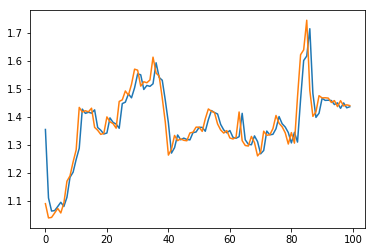

In [25]:
plt.plot(model.fittedvalues)
plt.plot(combined_residual[0:100])
plt.show()

In [26]:
def step_forward(feeddata):
    order = st.arma_order_select_ic(feeddata,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
    model = ARMA(feeddata, order=order.bic_min_order).fit()
    predict = model.forecast()[0]
    return predict


In [29]:
import warnings
warnings.filterwarnings("ignore")

total_money = 1000
track = []
total = 0
number_of = 100
end = len(combined_residual)
for i in range(100, end):
    track.append(total_money + total * combined_residual[i-1])
    if i % 5 == 0:
        get_pred = step_forward(combined_residual[i-100:i])
        if get_pred > combined_residual[i-1]:
            total += number_of
            total_money -= number_of * combined_residual[i-1]
        elif get_pred <= combined_residual[i-1]:
            total -= number_of
            total_money += number_of * combined_residual[i-1]
        
track.append(total_money + total * combined_residual[end-1])        

IndexError: index 734 is out of bounds for axis 0 with size 734

In [30]:
track.append(total_money + total * combined_residual[end-1])        

In [33]:
end = len(combined_residual)


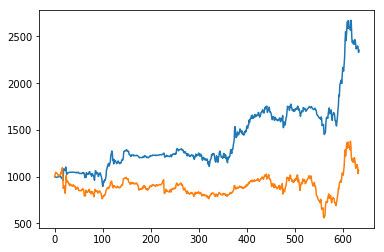

In [34]:
track = np.array(track)
r = []
for i in range(100, end):
    r.append(combined_residual[i]/combined_residual[100] * 1000)
plt.plot(track)
plt.plot(np.array(r))
plt.show()

In [37]:
len(track)/252

2.5198412698412698

In [54]:
def get_the_para(track, bechmark):
    r= np.exp(np.log(track[-1]/track[0])/(len(track)/252)) - 1
    r_b = np.exp(np.log(bechmark[-1]/bechmark[0])/(len(bechmark)/252)) - 1
    sharp = []
    bench = []
    r_f = 0.05
    r_f_d = np.exp(np.log(1 + r_f)/252) - 1
    
    for i in range(1,len(track)):
        sharp.append(track[i]/track[i-1] -r_f_d)
    sharp = np.sqrt(252) * (np.array(sharp).mean())/(np.array(sharp).std())
    max_draw = 0
    max_l = 0
    min_l = max(track)
    for i in range(len(track)):
        if track[i] > max_l:
            max_l = track[i]
        if track[i] < min_l:
            min_l = track[i]
            max_draw = max(max_draw, (max_l - min_l)/max_l)
    return {'Annual Return:':r, "BenchMark:": r_b, "Annual Sharpe Ratio:":sharp, "max_drawdown:":max_draw}

In [55]:
result = get_the_para(track, combined_residual[100::])

In [56]:
result

{'Annual Return:': 0.40476754167016149,
 'Annual Sharpe Ratio:': 2.4840922129506984,
 'BenchMark:': 0.026855319750983542,
 'max_drawdown:': 0.18920777168933092}